In [289]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

In [290]:
def get_stock_data(stock_name, normalized=0):
    #url="http://www.google.com/finance/historical?q="+stock_name+"&startdate=Jul+12%2C+2013&enddate=Jul+11%2C+2017&num=300&ei=rCtlWZGSFN3KsQHwrqWQCw&output=csv"
    url="http://www.google.com/finance/historical?q=%s&ei=u-lHWfGPNNWIsgHHqIqICw&output=csv" % stock_name 


    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv("/Users/ajohnson/Downloads/googl.csv", header=0, names=col_names) 
    df = pd.DataFrame(stocks)
    df.drop(df.columns[[0,3,5]], axis=1, inplace=True) 
    return df

In [291]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,0)

In [292]:
df.tail()

,Open,High,Close
1002,433.09,433.42,427.26
1003,434.16,437.43,433.30
1004,437.94,439.19,436.61
1005,444.44,447.50,438.48
1006,441.81,445.12,444.44


In [262]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)

In [279]:
type(df.Open[0])

numpy.float64

In [72]:
df.Close = pd.to_numeric(df.Close)

In [293]:
df['High'] = df['High'] / 1000
df['Open'] = df['Open'] / 1000
df['Close'] = df['Close'] / 1000
df.head(5)

,Open,High,Close
0,0.96600,0.97581,0.97372
1,0.95625,0.96618,0.96481
2,0.94274,0.96543,0.95990
3,0.93669,0.94408,0.93743
4,0.93945,0.93975,0.93428


In [265]:
len(df.as_matrix())

1007

In [281]:
def load_data(stock, seq_len):
    nFeatures = len(stock.columns)
    data = stock.as_matrix()
    sequence_length = seq_len+1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    testRow = round(0.9 * result.shape[0])
    train = result[:int(testRow), :]
    train_x = train[:, :-1]
    train_y = train[:, -1][:, -1]
    test_x = result[int(testRow):, :-1]
    test_y = result[int(testRow):, -1][:, -1]
    
    train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], nFeatures))
    test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], nFeatures))
    return [train_x, train_y, test_x, test_y]

In [282]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
    model.add(Dense(16, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model
    
    

In [294]:
window = 5
train_X, train_Y, test_X, test_Y = load_data(df[::-1], window)
print("train_X", train_X.shape)
print("train_Y", train_Y.shape)
print("test_X", test_X.shape)
print("test_Y", test_Y.shape)

train_X (901, 5, 3)
train_Y (901,)
test_X (100, 5, 3)
test_Y (100,)


In [269]:
test_Y

array([ 0.95671,  0.95484,  0.95589,  0.95514,  0.95922,  0.96461,
        0.94217,  0.9505 ,  0.95465,  0.96407,  0.97055,  0.97761,
        0.99186,  0.99327,  0.99617,  0.98709,  0.98829,  0.99612,
        1.00388,  0.99668,  1.00159,  1.00428,  0.97012,  0.96181,
        0.9705 ,  0.96793,  0.96018,  0.95862,  0.97522,  0.96899,
        0.97859,  0.97662,  0.98609,  0.97209,  0.94809,  0.96101,
        0.93782,  0.92968,  0.91946,  0.93226,  0.92769,  0.94081,
        0.951  ,  0.95353,  0.96766,  0.96885,  0.97691,  0.97596,
        0.98695,  0.99277,  0.99219,  0.99384,  0.99831,  0.96903,
        0.96531,  0.95251,  0.95833,  0.9455 ,  0.94656,  0.94764,
        0.9403 ,  0.94579,  0.94575,  0.94419,  0.94008,  0.92359,
        0.93009,  0.93893,  0.93808,  0.94427,  0.92766,  0.92618,
        0.92087,  0.9404 ,  0.94258,  0.93689,  0.9305 ,  0.92813,
        0.93575,  0.94363,  0.95524,  0.95199,  0.94148,  0.94202,
        0.94989,  0.94141,  0.94329,  0.94665,  0.95044,  0.94

In [295]:
model = build_model([3, window,1])

In [296]:
model

In [297]:
model.fit(
    train_X,
    train_Y, 
    batch_size=512,
    epochs=500, 
    validation_split=0.1, 
    verbose=0)

In [286]:
trainScore = model.evaluate(train_X, train_Y, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(test_X, test_Y, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [287]:
diff = []
ratio = []
p = model.predict(test_X)
for i in range(len(test_Y)):
    predicted = p[i][0]
    ratio.append(test_Y[i]/predicted - 1)
    diff.append(abs(test_Y[i] - predicted))
    print(i, test_Y[i], predicted, test_Y[i]/predicted - 1, abs(test_Y[i] - predicted))

0 0.95671 0.932559 0.0258974113066 0.024150867424
1 0.95484 0.937405 0.018599228707 0.0174350098038
2 0.95589 0.940615 0.0162398278729 0.0152754188919
3 0.95514 0.941173 0.014839845325 0.0139668637657
4 0.95922 0.94161 0.0187022913951 0.0176102597427
5 0.96461 0.941908 0.0241017507094 0.0227016404724
6 0.94217 0.941502 0.0007099112269 0.000668382568359
7 0.9505 0.942301 0.00870151443655 0.00819944190979
8 0.95465 0.942922 0.0124382564642 0.0117283019066
9 0.96407 0.94261 0.0227660933837 0.0214595573616
10 0.97055 0.941627 0.0307157603838 0.0289227955818
11 0.97761 0.940098 0.0399026322139 0.037512369976
12 0.99186 0.943054 0.0517526458864 0.0488055623627
13 0.99327 0.949424 0.0461817192838 0.043846031208
14 0.99617 0.956081 0.0419310316857 0.0400894440842
15 0.98709 0.962594 0.0254477429195 0.0244958485031
16 0.98829 0.967717 0.0212588826778 0.0205725908661
17 0.99612 0.971839 0.0249841397187 0.024280572052
18 1.00388 0.97299 0.0317475881971 0.0308900831985
19 0.99668 0.973255 0.024068

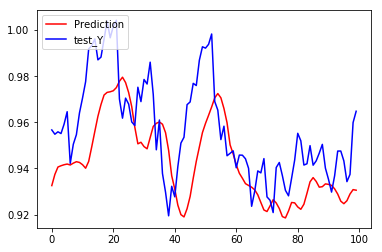

In [288]:
plt.plot(p, color='red', label='Prediction')
plt.plot(test_Y, color='blue', label='test_Y')
plt.legend(loc='upper left')
plt.show()

In [164]:
df.Close

0      0.10964
1      0.10925
2      0.10928
3      0.10911
4      0.10883
5      0.10910
6      0.10936
7      0.10964
8      0.11007
9      0.11028
10     0.11023
11     0.11033
12     0.11050
13     0.11041
14     0.11021
16     0.10963
17     0.10951
18     0.10896
19     0.10990
20     0.10960
21     0.10864
22     0.10795
23     0.10775
24     0.10770
25     0.10742
26     0.10767
27     0.10824
28     0.10694
29     0.10705
30     0.10730
        ...   
219    0.09203
220    0.09144
221    0.09158
222    0.09193
223    0.09138
224    0.09037
225    0.08999
226    0.08861
228    0.08844
229    0.08869
230    0.08957
231    0.08982
232    0.09044
233    0.09064
234    0.09068
235    0.09101
236    0.09070
237    0.09127
238    0.09140
239    0.09093
240    0.09045
241    0.09101
242    0.09000
243    0.09110
244    0.09108
245    0.09261
247    0.09233
248    0.09234
249    0.09170
250    0.09196
Name: Close, Length: 247, dtype: float64

In [107]:
result[:int(row), :]

array([[[ 0.10938,  0.10972,  0.10964],
        [ 0.1093 ,  0.10936,  0.10925],
        [ 0.10925,  0.10936,  0.10928],
        [ 0.10935,  0.10935,  0.10911],
        [ 0.10933,  0.10936,  0.10883],
        [ 0.10924,  0.10924,  0.1091 ]],

       [[ 0.1093 ,  0.10936,  0.10925],
        [ 0.10925,  0.10936,  0.10928],
        [ 0.10935,  0.10935,  0.10911],
        [ 0.10933,  0.10936,  0.10883],
        [ 0.10924,  0.10924,  0.1091 ],
        [ 0.1096 ,  0.1096 ,  0.10936]],

       [[ 0.10925,  0.10936,  0.10928],
        [ 0.10935,  0.10935,  0.10911],
        [ 0.10933,  0.10936,  0.10883],
        [ 0.10924,  0.10924,  0.1091 ],
        [ 0.1096 ,  0.1096 ,  0.10936],
        [ 0.11   ,  0.1101 ,  0.10964]],

       ..., 
       [[ 0.093  ,  0.093  ,  0.09277],
        [ 0.09285,  0.09286,  0.09281],
        [ 0.0925 ,  0.09257,  0.09257],
        [ 0.09174,  0.09212,  0.09203],
        [ 0.092  ,  0.092  ,  0.09144],
        [ 0.09122,  0.09158,  0.09158]],

       [[ 0.09285, 

In [136]:
x = np.array([[ 0,  1,  2],[ 3,  4,  5],[ 6,  7,  8],[ 9, 10, 11]])

In [137]:
x

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [162]:
x[:-1]

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])